In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import field_map_config_run1 as map_config

from IPython.display import clear_output

pair_dict = map_config.pair_dict

def __multipole(order, skew, strength, x_pos, y_pos):
    """Returns the magnitude of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * (r_pos/4.5)**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * (r_pos/4.5)**order * np.sin(order*theta)
    return b_magnitude


Welcome to JupyROOT 6.22/02


In [2]:
tr_df = pd.read_hdf('hdf5/2020-09-30_run_1a.h5', key='tr_df_1')

cols = ['tr_phi'] + ['tr'+str(pr) for pr in range(17)]
tr_df = tr_df[cols]

_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 10, 12]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0 , 0]
order_names = ['dipole', 'nq', 'sq', 'ss', 'ns', 'so', 'no', 'nd', 'sd', 'n12', 's12', 'n14', 'n16', 's16', 'n18', 'n22', 'n24']
_MULTS = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(17)])
_MULTS[np.abs(_MULTS) < 1.0e-9] = 0 

THETA_TR = np.linalg.pinv(np.transpose(_MULTS))
# THETA_TR = np.insert(THETA_TR, 12, np.zeros(17), 0)  ## without these lines, be CAREFUL about the m1, m2... notation
# THETA_TR = np.append(THETA_TR, np.zeros([2,17]), 0)
# THETA_TR[np.abs(THETA_TR) < 1.0e-9] = 0

In [ ]:
tr_df.to_csv('trolley_for_tim.csv')

In [3]:
def calc_moment_df(interp_df, trunc, theta_tr):
    
    moment_df = pd.DataFrame(index=interp_df.index)
    
    moment_df['tr_phi'] = interp_df['tr_phi'].copy()
    print 'Calculating trolley moments.',
    for m in np.arange(trunc):
        tr_probes = ['tr'+str(probe) for probe in np.arange(17)]
        moment_df['tr,m'+str(m+1)] = interp_df[tr_probes].dot(theta_tr[m])

    print '\rFinished calculating all moments for ' + str(moment_df.shape[0]) + ' events.'
    
    return moment_df


In [4]:
trunc_moments = np.full((17,17), np.nan)

for trunc in range(1,18):

    order = _MULTIPOLE_ORDER[:trunc]
    skew = _MULTIPOLE_SKEW[:trunc]
    mults = np.array([__multipole(order[i], skew[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(trunc)])
    THETA_TR = np.linalg.pinv(mults.T)

    mo_df = calc_moment_df(tr_df, trunc, THETA_TR)
    mo_df = mo_df.sort_values(by=['tr_phi'])
    phi = mo_df['tr_phi'].values
    dphi = (np.roll(phi, -1) - np.roll(phi, 1))/2
    dphi[0] = (dphi[0]+180)/2
    dphi[-1] = (dphi[-1]+180)/2

    cols = ['tr,m'+str(m+1) for m in range(trunc)]

    trunc_moments[trunc-1, 0:trunc] = np.average(mo_df[cols].values, axis=0, weights=dphi)


Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4386 events.


In [ ]:
def num_to_str(num, round_):
    exp = np.floor(np.log10(np.abs(num)))
    arg = np.round(num / (10.0**exp), round_)
    exp = int(exp)
    return str(arg)+'e'+str(exp)

In [ ]:
mean_str = num_to_str(np.nanmean(trunc_moments[:,1]), 3)

print mean_str
print float(mean_str)

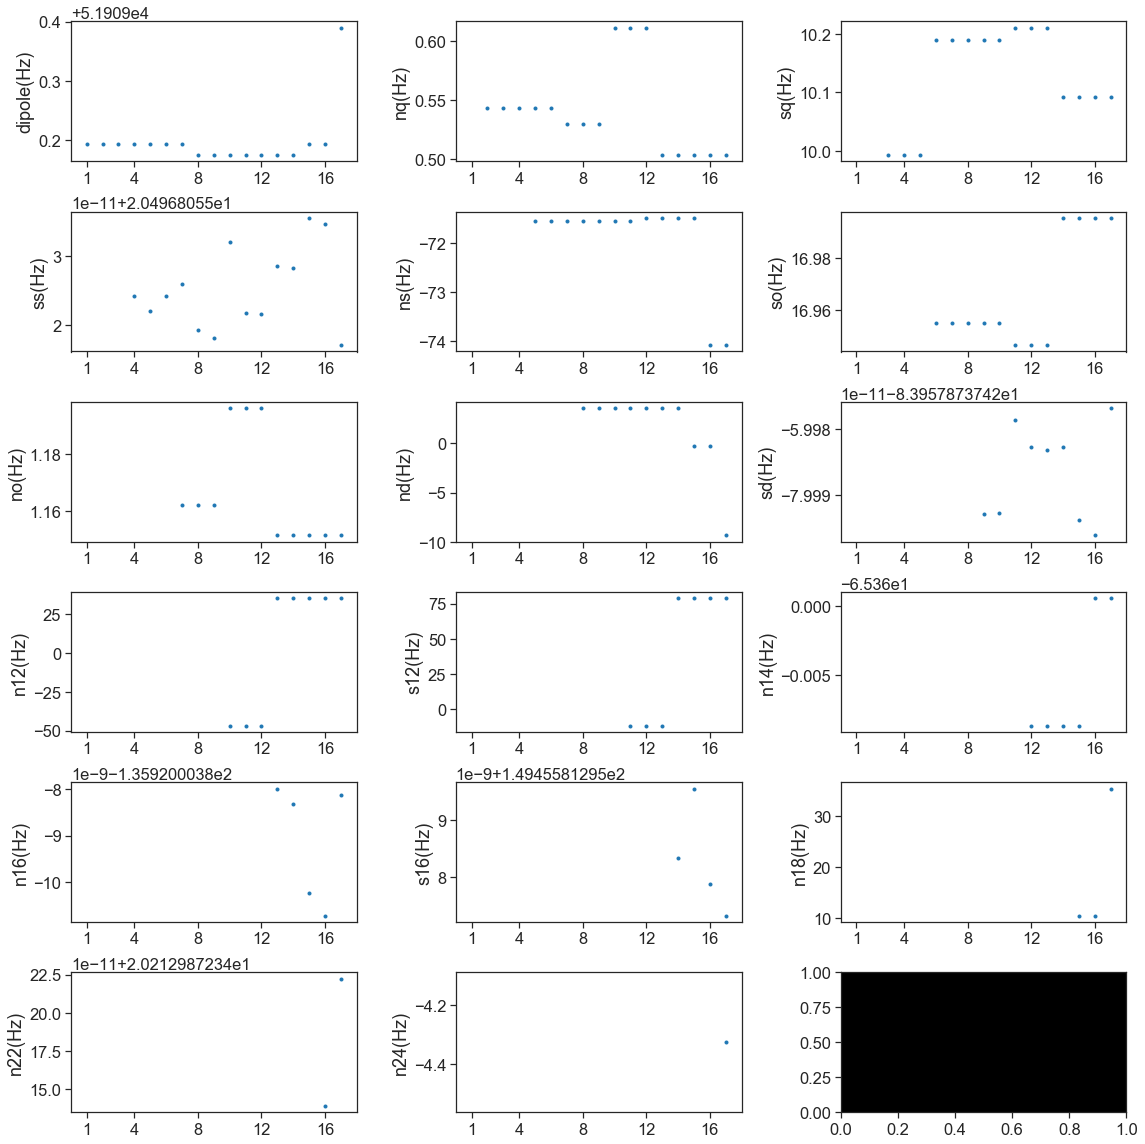

In [12]:
fig, axs = plt.subplots(6,3)

ii=0
for row in axs:
    for ax in row:
        if ii >=17:
            ax.set_facecolor('black')
            break
        ax.plot(trunc_moments[:,ii], '.')
        ax.set_xlim(0,17)
        ax.set_ylabel(order_names[ii] + '(Hz)')
        ax.set_xlim((-1,17))
        ax.set_xticks([0, 3, 7, 11, 15])
        ax.set_xticklabels([1, 4, 8, 12, 16])
        ii += 1
        
fig.set_size_inches(16,16)
fig.tight_layout()

In [ ]:
for item in np.round(np.nanstd(trunc_moments, axis=0),4):
    print str(item), '\t\t',